In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.signal as signal
import pandas as pd
from sklearn.decomposition import PCA
import math
import warnings
warnings.filterwarnings('ignore')
import scipy.signal as signal
import os


import numpy as np
from scipy import signal

import numpy as np
from scipy.signal import iirdesign, sosfilt

In [2]:
# Load exercise dataset 
exercise_dataset = scipy.io.loadmat('exercise_data.50.0000_singleonly.mat', struct_as_record=False)

# Load activities and data full objects
exercise_constants = exercise_dataset['exerciseConstants'][0][0].activities
subject_data = exercise_dataset['subject_data']

# extract activities names into an array
all_activities = []
for act in exercise_constants[0]:
    all_activities.append(act[0])
    #print (act[0]) # print values for reference



In [3]:
activities_to_process = all_activities

In [4]:
# define dictionaries for accelerometer and gyroscope data

rep_counts_actual = []
set_reps= {}
set_idx = 0
acc_signal = {}
gyr_signal = {}
# iterate over subject data to search for those activities and save the data related
for data_item in subject_data:
    for x in data_item:
        #print(x)
        
        if len(x) > 0:
            if x[0] is not None and len(x[0]) > 0:
                #print(x[0,0])
                data_activity_name = x[0,0].activityName[0]
                data_activity_reps = x[0,0].activityReps[0]
                data_item_accelDataMatrix = x[0,0].data[0,0].accelDataMatrix
                data_item_gyroDataMatrix = x[0,0].data[0,0].gyroDataMatrix
                if data_activity_name in activities_to_process:
                    #activities_accelerometer_data_dict[data_activity_name].append(data_item_accelDataMatrix)
                    #activities_gyroscope_data_dict[data_activity_name].append(data_item_gyroDataMatrix)
                    #rep_counts_actual.append(data_activity_reps)
                    set_reps[set_idx] =(data_activity_name, data_activity_reps[0])
                    acc_signal[set_idx] = data_item_accelDataMatrix
                    gyr_signal[set_idx] = data_item_gyroDataMatrix

                set_idx += 1



In [9]:

def signal_visualization(signal):

    t, x, y, z = [], [], [], []

    for time_point in signal:

        t.append(time_point[0])
        x.append(time_point[1])
        y.append(time_point[2])
        z.append(time_point[3])

    
    fig, ax = plt.subplots()
    ax.plot(t, x, label = 'X')
    ax.plot(t, y, label = 'Y')
    ax.plot(t, z, label = 'Z')

    ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title='')
    ax.grid()

    fig.tight_layout()
    fig.set_size_inches(25, 5)

    #plt.legend()
    #plt.show()

    #file_path = os.path.join('plots', 'sample_plot.png')
    #plt.savefig(file_path)

    return plt
    
      

def signal_decomposer(signal):

    t, x, y, z = [], [], [], []

    for time_point in signal:

        t.append(time_point[0])
        x.append(time_point[1])
        y.append(time_point[2])
        z.append(time_point[3])

    
    return t,x,y,z

def signal_component_visualizer(t,component):

    fig, ax = plt.subplots()
    ax.plot(t, component, label = 'X')
    #ax.plot(t, y, label = 'Y')
    #ax.plot(t, z, label = 'Z')

    ax.set(xlabel='Time (seconds)', ylabel='Acceleration output (g)', title='')
    ax.grid()

    fig.tight_layout()
    fig.set_size_inches(25, 5)

    #plt.legend()
    #plt.show()

    return fig,ax




In [10]:

def apply_elliptical_bandpass_filter(signal):

    # Define filter specifications
    low_cutoff = 0.15  # Lower cutoff frequency in Hz
    high_cutoff = 11.0  # Upper cutoff frequency in Hz
    stop_low = 0.1  # Lower stopband frequency in Hz
    stop_high = 12.0  # Upper stopband frequency in Hz
    filter_order = 4  # Filter order

    t,x,y,z = signal_decomposer(signal)

    # Convert time points to equally spaced samples
    time_step = t[1] - t[0]  # Assuming time array is equally spaced
    sampling_freq = 1.0 / time_step

    # Perform elliptical bandpass filtering
    sos = iirdesign(wp=[low_cutoff, high_cutoff], ws=[stop_low, stop_high], gpass=1, gstop=60, fs=sampling_freq, output='sos')
    filtered_signal_x = sosfilt(sos, x)
    filtered_signal_y = sosfilt(sos, y)
    filtered_signal_z = sosfilt(sos, z)


    return filtered_signal_x,filtered_signal_y,filtered_signal_z

def signal_combiner(t,signal_x, signal_y,signal_z):

    x = signal_x 
    y = signal_y 
    z = signal_z

    return [np.array([t[i],x[i],y[i],z[i]]) for i in range(len(t))]

def signal_dataframe_creator(signal):

    frame = pd.DataFrame(signal)
    frame.rename(columns= {0:'t',1:'x',2:'y',3:'z'},inplace=True)

    return frame

def pc1(filtered_frame):

    t = filtered_frame[['t']]
    new_frame = filtered_frame[['x','y','z']]
    new_frame = new_frame - new_frame.mean()
    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(new_frame)
    pca_frame = pd.DataFrame(pca_result)
    concatenated = pd.concat([t,pca_frame], axis=1)
    concatenated.rename(columns = {0:'pc_values'},inplace=True)


    return concatenated

In [11]:
relevant_sets_idx = []

for idx in set_reps:
    if set_reps[idx][1] > 0:
        relevant_sets_idx.append(idx)

In [12]:
sample_signal = acc_signal[5]

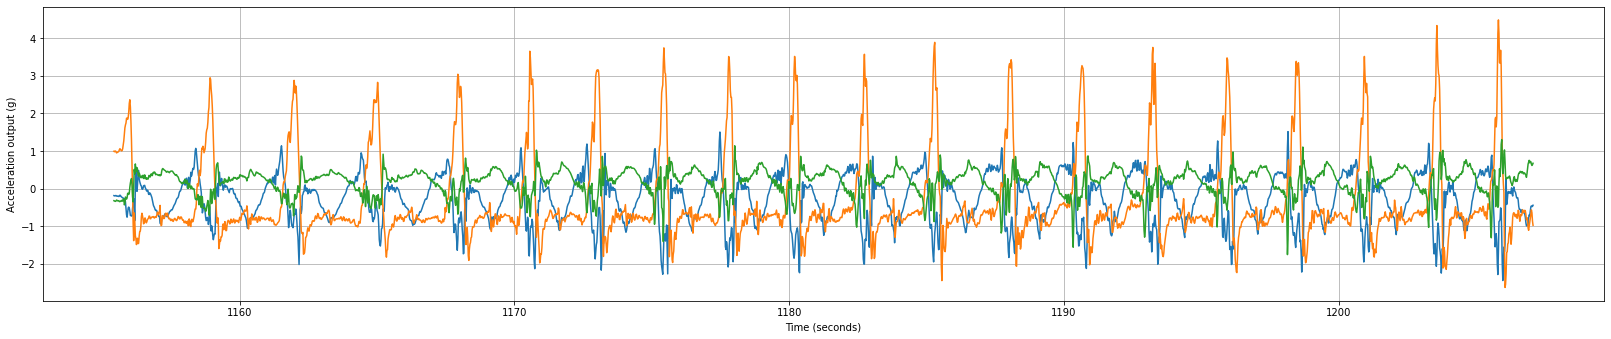

In [13]:
plot  =  signal_visualization(sample_signal)

In [14]:
set_reps[5]

('Butterfly Sit-up', 20)

In [15]:
import numpy as np
import statsmodels.api as sm

class ExerciseSet:
    def __init__(self,set_idx,exercise_name,reps,acc_signal,gyr_signal):
        self.set_idx = set_idx
        self.exercise_name = exercise_name
        self.reps = reps
        self.acc_signal = acc_signal
        self.gyr_signal = gyr_signal
        self.t = self.acc_signal[:,0]
        self.principle_component = self.principle_component_maker()
        self.num_time_points = len(self.t)
        self.set_time = self.num_time_points * 0.02
        self.seasonality = self.seasonality_finder(self.principle_component['pc_values'])
        self.reps_pred = self.reps_predictor()
        
    def principle_component_maker(self):
        t,x,y,z = signal_decomposer(self.acc_signal)
        fil_x,fil_y,fil_z = apply_elliptical_bandpass_filter(self.acc_signal)
        filtered_frame = signal_dataframe_creator(signal_combiner(t,fil_x,fil_y,fil_z))
        pc_frame = pc1(filtered_frame)

        return pc_frame
    
    def seasonality_finder(self,data,min_threshold=40):

        acf_values = sm.tsa.acf(data, nlags=len(data)-1, fft=True)

        max_index = acf_values[min_threshold:].argmax()
            
        return min_threshold,min_threshold + max_index

    def reps_predictor(self):

        return round(len(self.t)/ self.seasonality[1],0)



In [16]:
set_dict = {}

for i in relevant_sets_idx:
    set_dict[i] = ExerciseSet(i,set_reps[i][0],set_reps[i][1],acc_signal[i],gyr_signal[i])
    

In [17]:
sample_set = set_dict[3]

In [18]:
print(sample_set.exercise_name)
print(sample_set.reps)
print(sample_set.seasonality)
print('seasonality in seconds ={}'.format(sample_set.seasonality[1]*0.02))
print(sample_set.num_time_points)
print(sample_set.set_time)
print(sample_set.reps_pred)



Biceps Curl (band)
20
(40, 121)
seasonality in seconds =2.42
2428
48.56
20.0


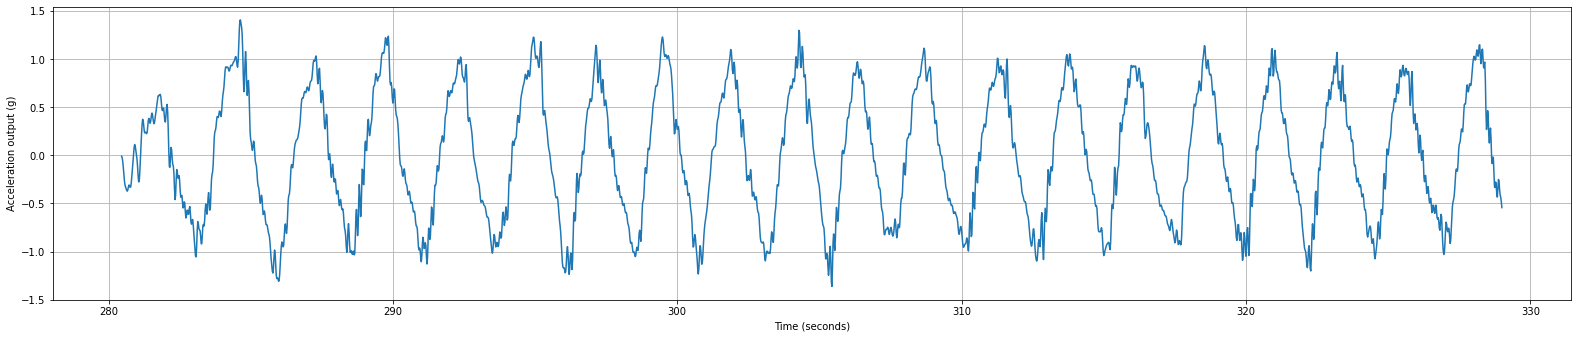

In [19]:
fig,ax = signal_component_visualizer(sample_set.t,sample_set.principle_component['pc_values'])

In [34]:
def accuracy_finder(set_dict,relevant_sets_idx,threshold):

    right_preds = []

    for idx in relevant_sets_idx:
        if abs(set_dict[idx].reps - set_dict[idx].reps_pred) <= threshold:
            right_preds.append(idx)

    return len(right_preds)/len(set_dict)
    
def mae_calculator(set_dict,relevant_sets_idx):

    abs_diff = []

    for idx in relevant_sets_idx:
        abs_diff.append(abs(set_dict[idx].reps - set_dict[idx].reps_pred))


    return np.mean(abs_diff),np.median(abs_diff)


    

In [35]:
for threshold in range(10):
    print(accuracy_finder(set_dict,relevant_sets_idx,threshold))

0.5101214574898786
0.7368421052631579
0.7870445344129555
0.8194331983805668
0.8388663967611336
0.8591093117408907
0.8801619433198381
0.8987854251012146
0.9068825910931174
0.9157894736842105


In [36]:
mae_calculator(set_dict,relevant_sets_idx)

(3.025910931174089, 0.0)

In [24]:
def plots_saver(set_dict,folder_name,min_idx,max_idx):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for idx in set_dict:

    
        if idx < max_idx and idx >= min_idx:
        
            set = set_dict[idx]
            file_name = str(idx)
            fig,ax = signal_component_visualizer(set.t,set.principle_component['pc_values'])
            filepath = os.path.join(folder_name,file_name)
            fig.savefig(filepath)

    


    

In [42]:
#plots_saver(set_dict,'reps_plots',1500,2000)

In [43]:
#plots_saver(set_dict,'reps_plots',2000,max(set_dict.keys()))